In [1]:
import math
import json
import os

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import cross_val_score, cross_val_predict
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator
from skimage import exposure

#import machineLearningUtilities.dataPreparation as mlU
import qrQuery
from IF2.Crop import croppingProcess as cP
from IF2.Marker import markerProcess as maP
from IF2.Marker import markerAugmentation as mA
from IF2.Processing import colorTransformations as cT
from IF2.Processing import imageOperations as iO
from IF2.Processing import indAnalysis as inA
from IF2.Processing import preProcessing as pP
from IF2.ReadImage import readImage as rI
from IF2.Shows.showProcesses import showImage as show
#from machineLearningUtilities import modelPerformance as mP
#from machineLearningUtilities import nnUtils as nnU

Using TensorFlow backend.


The module Crop has been successfuly imported from e:/unima/proyectos/imagefunctions/IF2/Crop
e:/unima/proyectos/imagefunctions/IF2/Crop
E:\Unima\Proyectos\AppProcessGab\Dataframe creation imported at location Dataframe creation


In [2]:
with open('../Database connections/connections.json') as jsonFile:
    connections = json.load(jsonFile)['connections']
zaptoConnection = connections['zapto']
zaptoImagesCollection = qrQuery.getCollection(
    zaptoConnection['URI'], zaptoConnection['databaseName'], zaptoConnection['collections']['markersCollectionName'])
markers = zaptoImagesCollection.find(
    {'diagnostic': {'$ne': None}}).sort('_id', 1).limit(1)
markersInfo = [[(iO.resizeFixed(rI.readb64(marker['image']))),
                {'diagnostic': marker['diagnostic'],
                 'name':  marker['marker'],
                 'qr': marker['QR'],
                 'count': marker['count'],
                 '_id': marker['_id']}
                ] for marker in markers]
markerImages = [info[0] for info in markersInfo]
markersInfo = [info[1] for info in markersInfo]
registerCount = len(markersInfo)

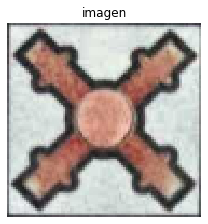

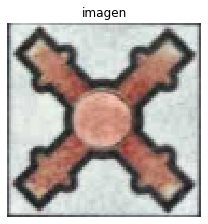

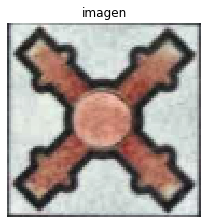

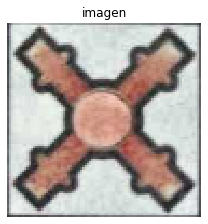

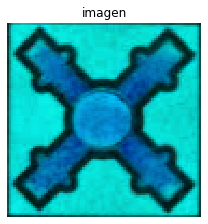

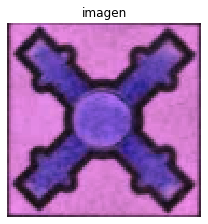

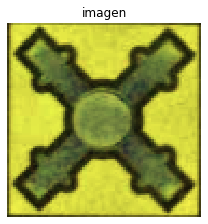

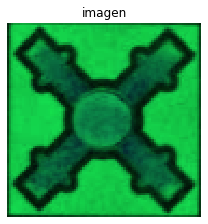

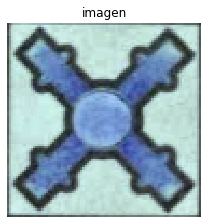

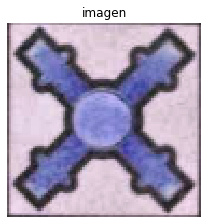

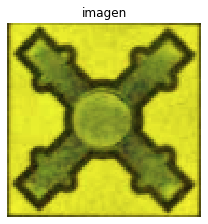

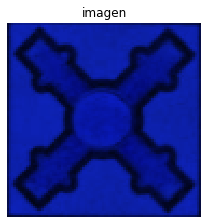

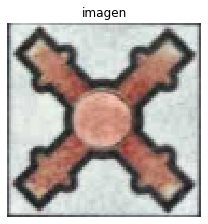

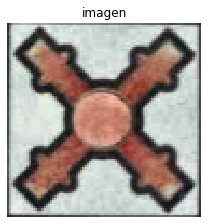

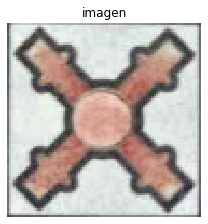

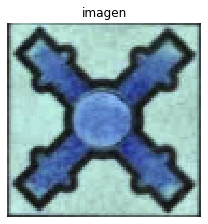

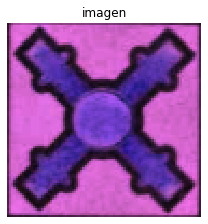

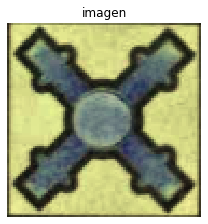

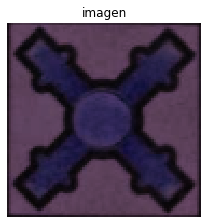

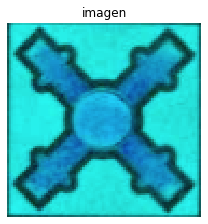

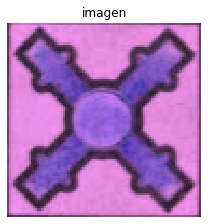

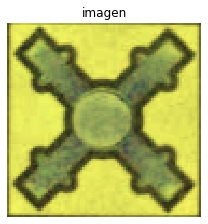

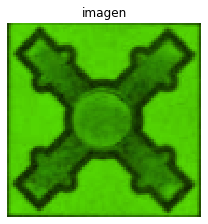

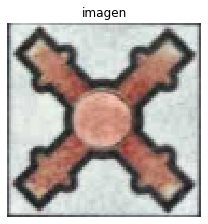

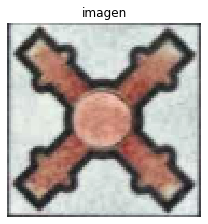

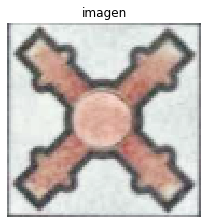

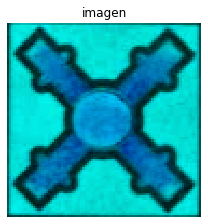

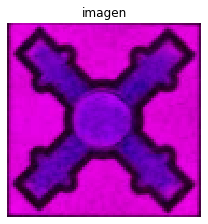

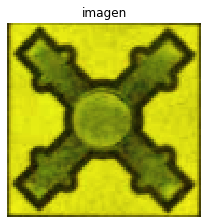

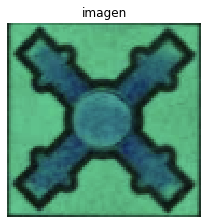

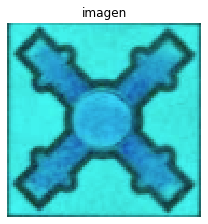

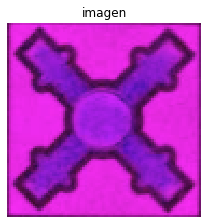

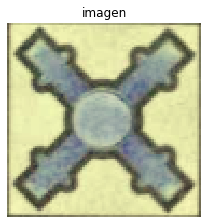

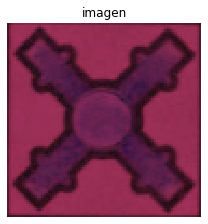

In [10]:
fullFeatures = []
for i, (marker, info) in enumerate(zip(markerImages, markersInfo)):
    markers = mA.augmentMarker(marker)
    for marker in markers:
        show(marker)

In [9]:
np.random.uniform(.5, 1.5, 3)

array([0.86981281, 0.57440187, 1.06591242])

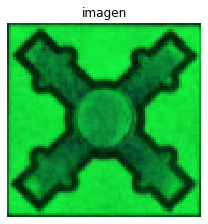

In [79]:
marker = markerImages[0]
show(marker)

In [ ]:
X = fullDataframe.iloc[:, :-1].values
y = fullDataframe.iloc[:, -1].values
y = y.astype('int')
X_train, X_test, y_train, y_test = mlU.splitData(X, y, seed=56)

In [ ]:
logisticRegr = LogisticRegression(solver='lbfgs', max_iter=1000, C = np.log(10))
logisticRegr.fit(X_train, y_train)
predictions = logisticRegr.predict(X_test)
score = logisticRegr.score(X_test, y_test)
cm = metrics.confusion_matrix(y_test, predictions)
print(cm)
plt.figure(figsize=(9, 9))
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5,
            square=True, cmap='Pastel1')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size=15)
plt.show()

In [ ]:
kf = cross_val_score(logisticRegr, X_train, y_train, cv=3)
#%%
print(kf.std())
print(kf.mean())

In [ ]:
precission = metrics.precision_score(y_test, predictions)
recall = metrics.recall_score(y_test, predictions)
f1 = metrics.f1_score(y_test, predictions)
print(precission, recall, f1)

In [ ]:
y_scores = cross_val_predict(logisticRegr, X_train, y_train, cv=3, method='decision_function')

In [ ]:
precisions, recalls, thresholds = metrics.precision_recall_curve(y_train, y_scores)

In [ ]:
plot_precission_recall_vs_thresholds(precisions, recalls, thresholds)
#plot_precision_vs_recall(precisions, recalls)
fpr, tpr, thresholds = metrics.roc_curve(y_train, y_scores)
#plot_roc_curve(fpr, tpr)
plt.show()

In [ ]:
plot_precision_vs_recall(precisions, recalls)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
forestClf = RandomForestClassifier(n_estimators=1000, random_state=42)
y_probas_forest = cross_val_predict(forestClf, X_train, y_train, cv=3, method='predict_proba')

In [ ]:
y_scores_forest= y_probas_forest[:, 1] # Probability of positive class
fpr_forest, tpr_forest, thresholds_forest = metrics.roc_curve(y_train, y_scores_forest)

In [ ]:
plot_roc_curve(fpr, tpr, label='LOGREG')
plot_roc_curve(fpr_forest, tpr_forest, label='RF')
plt.show()

In [ ]:
metrics.roc_auc_score(y_train, y_scores)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
neighClf = KNeighborsClassifier(n_neighbors=15)
y_probas_neigh = cross_val_predict(neighClf, X_train, y_train, cv=3, method='predict_proba')

In [ ]:
y_scores_neigh= y_probas_neigh[:, 1] # Probability of positive class
fpr_neigh, tpr_neigh, thresholds_neigh = metrics.roc_curve(y_train, y_scores_neigh)

In [ ]:
plot_roc_curve(fpr, tpr, label='LOGREG')
plot_roc_curve(fpr_neigh, tpr_neigh, label='KNN')
plt.show()

In [ ]:
#%% new preds
picturesPath = '../assetsForTests/neg_finger_blood/mid/'
picturesFullPath = [picturesPath+name for name in os.listdir(picturesPath) if name.endswith('.jpg') or name.endswith('.png') or name.endswith('.jpeg') or name.endswith('.JPG')]
pictures = [iO.resizeImg(rI.readLocal(path), 728) for path in picturesFullPath]
#%%

In [ ]:
markerNames = ['E6', 'CF', 'RV']
columns = ['fileName'] + markerNames
fullData = []
for i, (picture, name) in enumerate(zip(pictures, os.listdir(picturesPath))):
    testArea = cP.getTestArea(picture)
    markers = cP.getMarkers(testArea)[:-1]
    diags= []
    for marker in markers:
        markerGray = cT.BGR2gray(marker)
        marker1d = markerGray.reshape((1, -1))/255
        diagProb = logisticRegr.predict_proba(marker1d)[0][1]
        diag = logisticRegr.predict(marker1d)[0]
        diags.append(diagProb)
    diagStrings = ''.join([f'Diagnóstico para {marker}: {round(diag, 5)}\n' for marker, diag in zip(markerNames, diags)])
    data = [name] + diags
    fullData.append(data)
    show(testArea, title=diagStrings)
testDf2 = pd.DataFrame(fullData, columns=columns)

In [ ]:
testDf2

In [ ]:
testDf1

In [ ]:
testDf3